## Customer Segmentation using Online Retail Dataset

This project analyzes customer purchasing behavior using RFM (Recency, Frequency, Monetary) analysis.  
The goal is to identify high-value and low-value customers to support targeted marketing strategies.

### Dataset Details:
 Source: https://www.kaggle.com/datasets/ulrikthygepedersen/online-retail-dataset
 

In [1]:
!pip install pandas numpy matplotlib seaborn

### STEP 1: Importing Required Libraries
We import essential libraries for data manipulation and visualization: pandas, numpy, matplotlib, and seaborn.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ All libraries installed and imported successfully!")


Matplotlib is building the font cache; this may take a moment.


✅ All libraries installed and imported successfully!


In [4]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("online_retail.csv", encoding='latin1')  

# View first few rows
df.head()


FileNotFoundError: [Errno 2] No such file or directory: 'online_retail.csv'

In [5]:
import os
os.listdir()


['.config',
 'Music',
 '.zprofile.pysave',
 '.condarc',
 '.DS_Store',
 '.CFUserTextEncoding',
 '.xonshrc',
 'anaconda_projects',
 'Untitled.ipynb',
 '.zshrc',
 '.arduinoIDE',
 'Pictures',
 '.zprofile',
 '.zsh_history',
 '.ipython',
 'Desktop',
 'Library',
 '.matplotlib',
 '.cups',
 'Public',
 '.idlerc',
 '.tcshrc',
 '.anaconda',
 'Movies',
 '.Trash',
 '.ipynb_checkpoints',
 '.jupyter',
 'face recognition',
 '.vscode-insiders',
 'Documents',
 '.vscode',
 '.bash_profile',
 'Downloads',
 '.python_history',
 '.continuum',
 '.zsh_sessions',
 '.conda']

In [7]:
import pandas as pd

df = pd.read_csv("/Users/aasthasingh/Downloads/online_retail.csv", encoding='latin1')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [8]:
df.isnull().sum()


InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### STEP 2: Data Cleaning
Here removal of entries with missing 'CustomerID' and removal of any negative/invalid quantities is performed in order to clean the dataset.



In [9]:
df = df.dropna(subset=['CustomerID'])


In [10]:
df.shape


(406829, 8)

In [11]:
import datetime

# Set snapshot date = 1 day after last purchase
snapshot_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)
print("Snapshot Date:", snapshot_date)


TypeError: can only concatenate str (not "datetime.timedelta") to str

In [12]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [13]:
import datetime
snapshot_date = df['InvoiceDate'].max() + datetime.timedelta(days=1)
print("Snapshot Date:", snapshot_date)


Snapshot Date: 2011-12-10 12:50:00


In [15]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


### STEP 3: Creating RFM Table
#### A RFM table is created to calculate and tabulate 3 metrics for each customer: 
1.Recency: Days since the customer's last purchase
2.Frequency: Total number of unique purchases (invoices)
3.|Monetary: Total spending (Quantity × UnitPrice)

In [16]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,2,0.00
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


### STEP 4: RFM Scoring
Recency: Lower is better → score 4 (recent), 1 (old)
Frequency & Monetary: Higher is better → score 4 (frequent/high spenders)

In [17]:
# RFM Scoring (higher Frequency and Monetary are better, lower Recency is better)
r_scores = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
f_scores = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
m_scores = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Assign scores to the RFM table
rfm['R'] = r_scores.astype(int)
rfm['F'] = f_scores.astype(int)
rfm['M'] = m_scores.astype(int)

# Combine scores into one column
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# Show updated RFM table
rfm.head()


,Recency,Frequency,Monetary,R,F,M,RFM_Score
CustomerID,,,,,,,
12346.0,326,2,0.00,1,2,1,121
12347.0,2,7,4310.00,4,4,4,444
12348.0,75,4,1797.24,2,3,4,234
12349.0,19,1,1757.55,3,1,4,314
12350.0,310,1,334.40,1,1,2,112


In [18]:
def segment_customer(rfm):
    score = rfm['RFM_Score']
    if score == '444':
        return 'Champions'
    elif rfm['R'] >= 3 and rfm['F'] >= 3:
        return 'Loyal Customers'
    elif rfm['R'] == 4 and rfm['F'] <= 2:
        return 'Potential Loyalist'
    elif rfm['R'] == 1 and rfm['F'] >= 3:
        return 'At Risk'
    elif rfm['R'] == 1 and rfm['F'] == 1:
        return 'Lost'
    else:
        return 'Others'

# Apply segmentation
rfm['Segment'] = rfm.apply(segment_customer, axis=1)

# View some results
rfm[['RFM_Score', 'Segment']].head()


,RFM_Score,Segment
CustomerID,,
12346.0,121,Others
12347.0,444,Champions
12348.0,234,Others
12349.0,314,Others
12350.0,112,Lost


### STEP 5:Visualizing Customer Segments

Plotting a bar chart to show the number of customers in each segment to understand customer distribution.


/var/folders/gd/hf92mc3x3pn6zj46pjjds8rr0000gn/T/ipykernel_73280/4033046994.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')


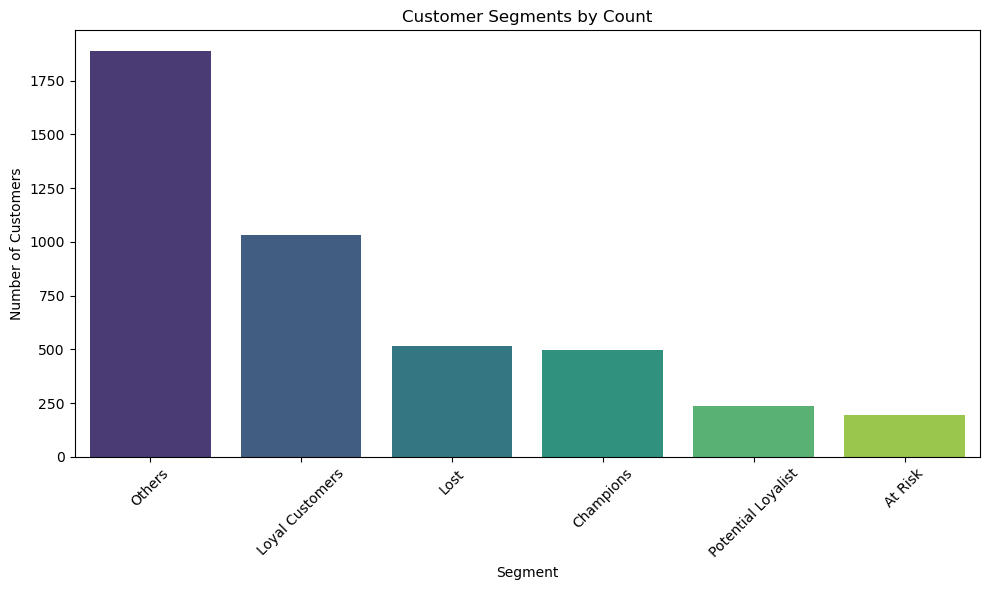

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='viridis')
plt.title('Customer Segments by Count')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [20]:
rfm.groupby('Segment')['Monetary'].mean().sort_values(ascending=False)


Segment
Champions             8780.148876
Loyal Customers       1966.322873
At Risk               1118.841500
Others                 742.475662
Potential Loyalist     520.065672
Lost                   290.084826
Name: Monetary, dtype: float64

### STEP 6: Exporting Results

Exporting the final segmented data to a CSV file for further use or dashboard creation.


In [21]:
rfm.to_csv("customer_segmentation_output.csv")


### Conclusion

- **Champions** and **Loyal Customers** drive the majority of revenue.
- **At Risk** and **Lost** segments can be re-targeted with offers.
- This segmentation allows for personalized marketing and retention strategies.

